In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import eom
import polaritons
import fft

20000


/Users/jroman/miniconda3/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


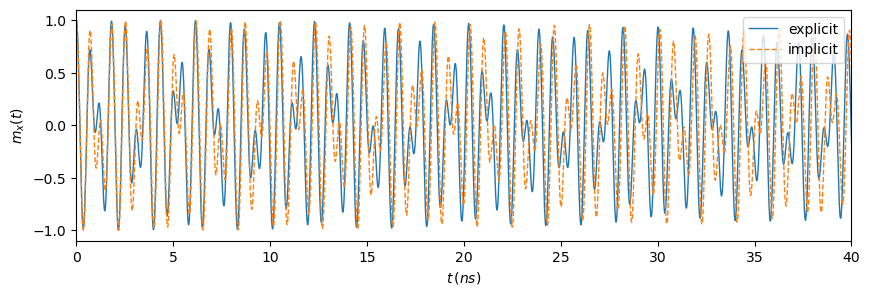

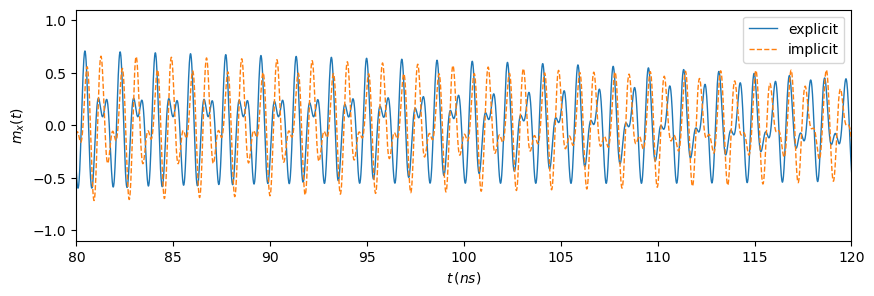

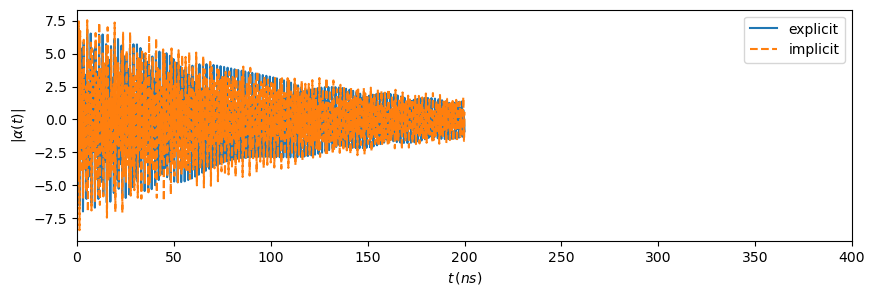

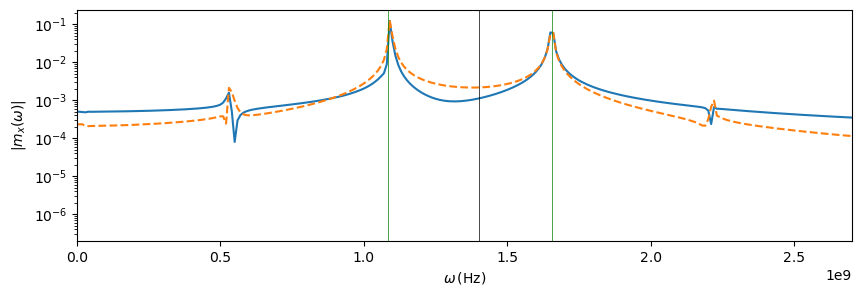

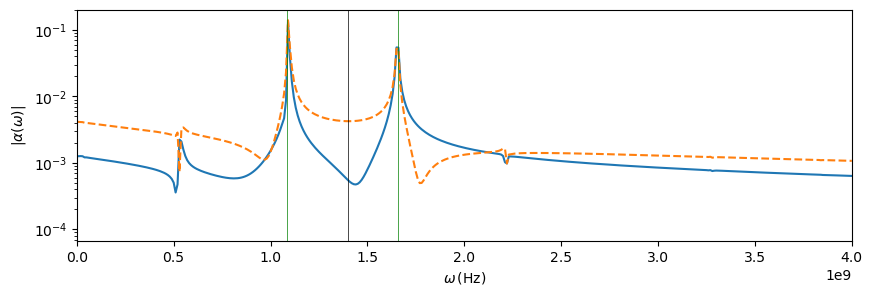

In [2]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 200e-9  # 1000
alpha = 1e-3
my0 = 0.01
# m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  # fijo alpha0 a partir de x0 y p0
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 1e-3 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
lam = 0.2 * wc
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])

lamc = 0.5 * np.sqrt(wc * wz)

dt = 0.01e-9
t_eval = np.linspace(0, tmax, int(tmax // dt) + 1)  # 100000
print(int(tmax // dt))
rtol = 0
atol = 1e-10
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)

# dt = 0.01e-9
eom.LLG_memory_1.S = 0
eom.LLG_memory_1.C = 0
eom.LLG_memory_1.last_t = 0.0
eom.LLG_memory_1.dS = eom.LLG_memory_1.dC = eom.LLG_memory_1.dt = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory_1,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)


plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 40)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(80, 120)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t * 1e9, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t * 1e9, np.real(alphas_imp), ls="dashed", label="implicit")
if lam > lamc:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha
    plt.axhline(
        -np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 400)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, sol_exp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, sol_imp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, alphas_exp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # calculo transformada fourier alphas

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 4e9)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

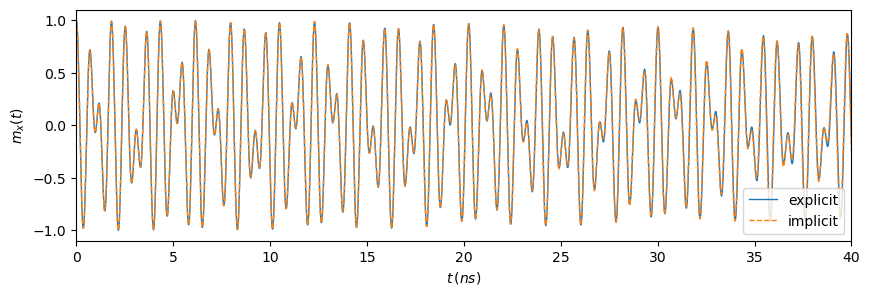

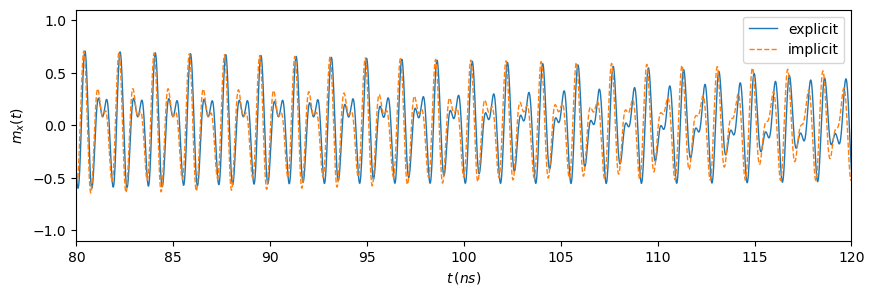

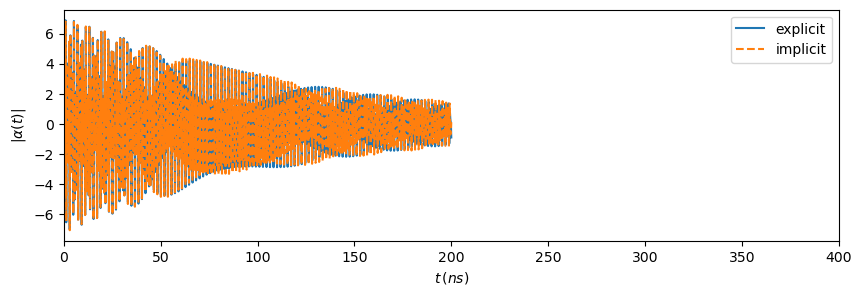

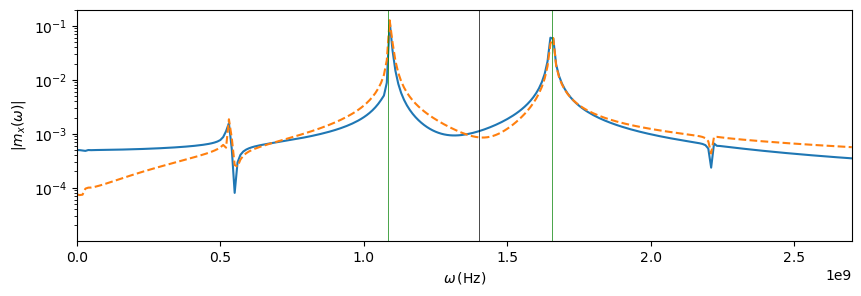

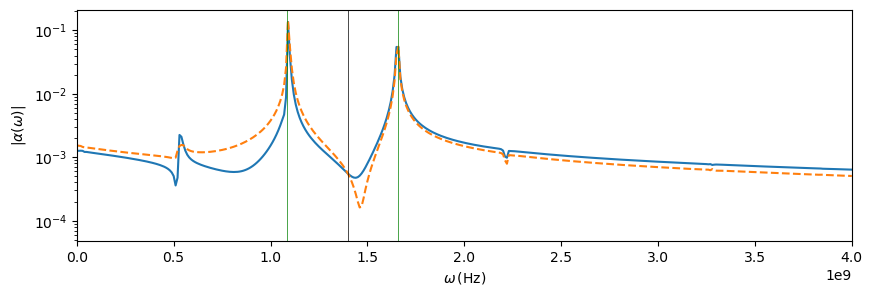

In [3]:
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)

# dt = 0.01e-9
eom.LLG_memory_2.S = 0
eom.LLG_memory_2.C = 0
eom.LLG_memory_2.last_t = 0.0
eom.LLG_memory_2.dS = eom.LLG_memory_2.dC = eom.LLG_memory_2.dt = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory_2,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)


plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 40)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(80, 120)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t * 1e9, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t * 1e9, np.real(alphas_imp), ls="dashed", label="implicit")
if lam > lamc:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha
    plt.axhline(
        -np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 400)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, sol_exp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, sol_imp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, alphas_exp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # calculo transformada fourier alphas

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 4e9)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

100000


/Users/jroman/miniconda3/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


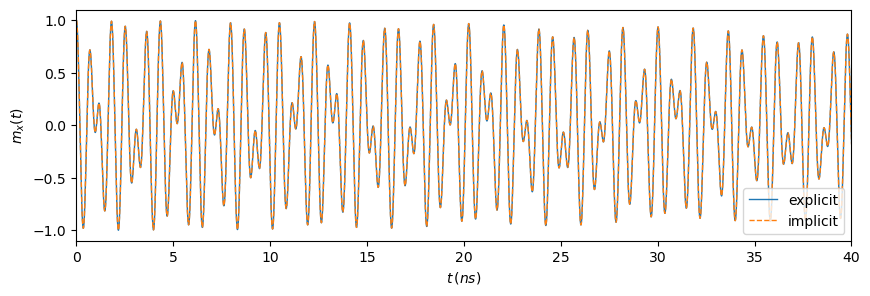

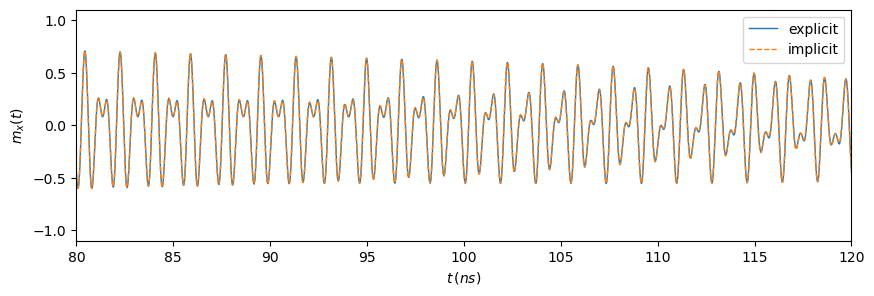

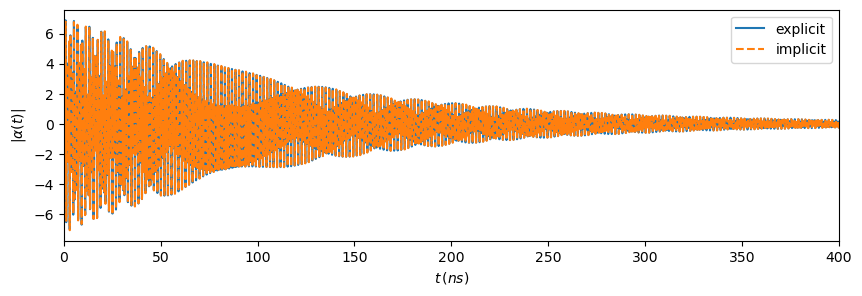

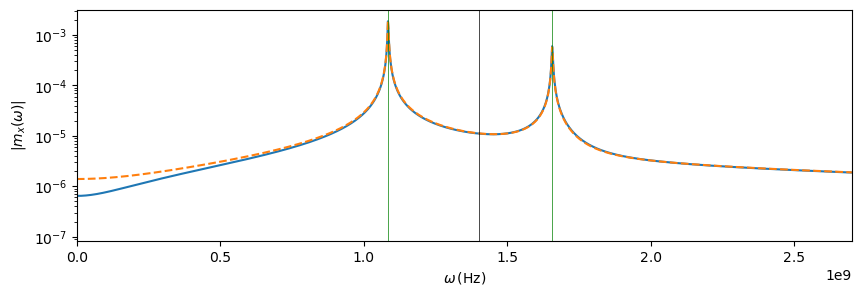

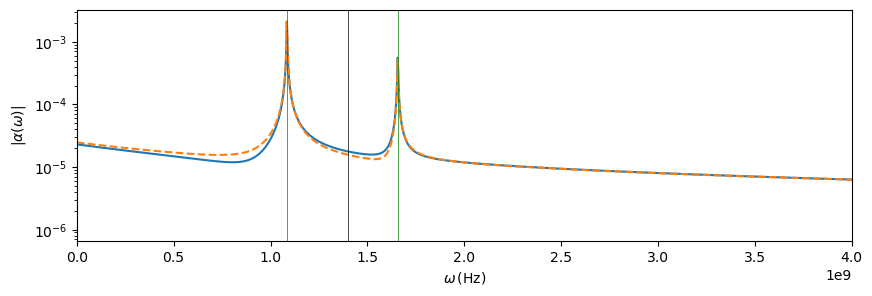

In [4]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 1000e-9  # 1000
alpha = 1e-3
my0 = 0.01
# m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  # fijo alpha0 a partir de x0 y p0
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 1e-3 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
lam = 0.2 * wc
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])

lamc = 0.5 * np.sqrt(wc * wz)

dt = 0.01e-9
t_eval = np.linspace(0, tmax, int(tmax // dt) + 1)  # 100000
print(int(tmax // dt))
rtol = 0
atol = 1e-16
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)

# dt = 0.01e-9
eom.LLG_memory_2.S = 0
eom.LLG_memory_2.C = 0
eom.LLG_memory_2.last_t = 0.0
eom.LLG_memory_2.dS = eom.LLG_memory_2.dC = eom.LLG_memory_2.dt = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory_2,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)


plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 40)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(80, 120)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t * 1e9, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t * 1e9, np.real(alphas_imp), ls="dashed", label="implicit")
if lam > lamc:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha
    plt.axhline(
        -np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 400)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, sol_exp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, sol_imp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, alphas_exp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # calculo transformada fourier alphas

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 4e9)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

100000


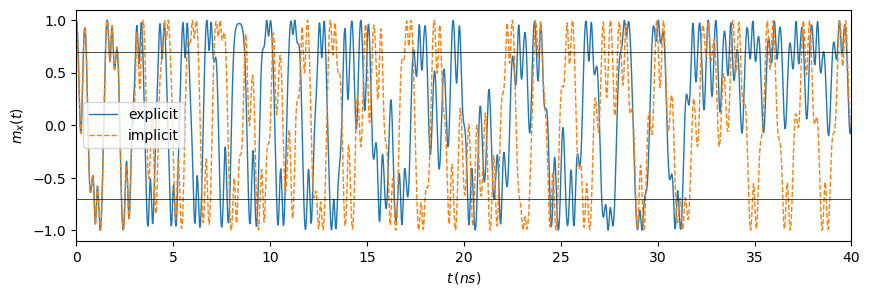

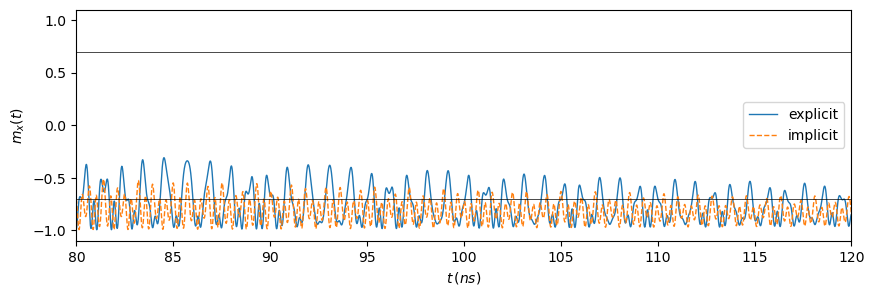

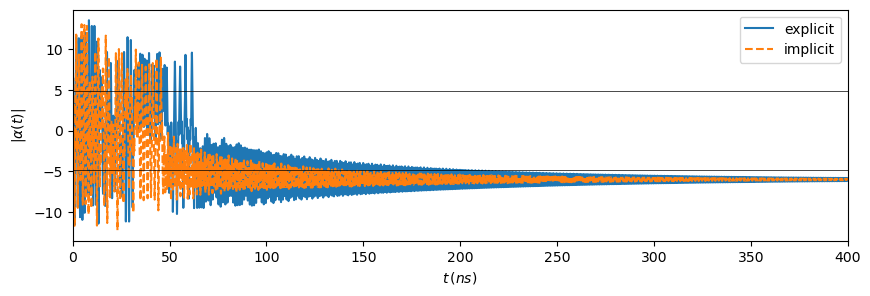

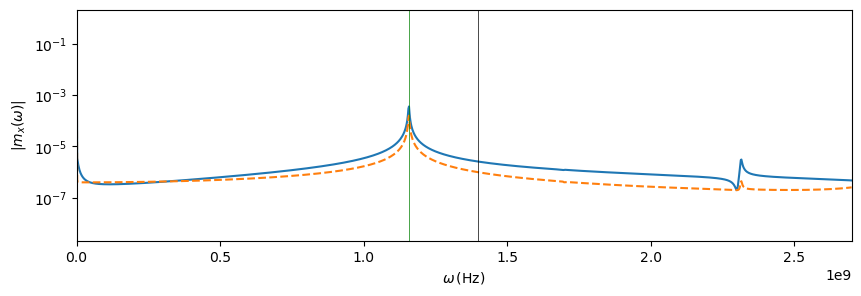

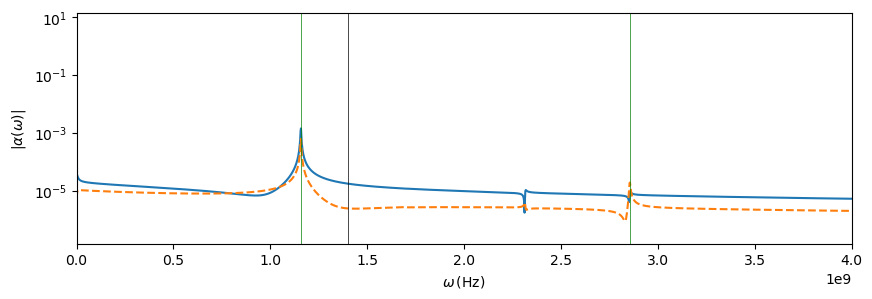

In [5]:
plt.rcParams["figure.figsize"] = (10, 3)

N = 100
tmax = 1000e-9  # 1000
alpha = 1e-3
my0 = 0.01
# m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0])
alpha0 = 0.5 * (m0[3] - 1j * m0[4])  # fijo alpha0 a partir de x0 y p0
gammaLL = 28e9 * 2 * np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 1e-3 * wc
Bext = np.array([0, 0, 2 * np.pi * wz / gammaLL])
lam = 0.7 * wc
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])

lamc = 0.5 * np.sqrt(wc * wz)

dt = 0.01e-9
t_eval = np.linspace(0, tmax, int(tmax // dt) + 1)  # 100000
print(int(tmax // dt))
rtol = 0
atol = 1e-16
sol_exp = solve_ivp(
    eom.LLG_explicit,
    (0, tmax),
    m0,
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)

# dt = 0.01e-9
eom.LLG_memory_2.S = 0
eom.LLG_memory_2.C = 0
eom.LLG_memory_2.last_t = 0.0
eom.LLG_memory_2.dS = eom.LLG_memory_2.dC = eom.LLG_memory_2.dt = 0.0
sol_imp = solve_ivp(
    eom.LLG_memory_2,
    (0, tmax),
    m0[:-2],
    args=(Bext, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha, m0[-2:]),
    t_eval=t_eval,
    # max_step=dt,
    atol=atol,
    rtol=rtol
)


plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(0, 40)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

plt.plot(sol_exp.t * 1e9, sol_exp.y[0], label="explicit", lw=1)
plt.plot(sol_imp.t * 1e9, sol_imp.y[0], ls="dashed", label="implicit", lw=1)
if lam > lamc:
    plt.axhline(np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx
    plt.axhline(-np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5)  # stationary mx

plt.xlim(80, 120)
# plt.ylim(-0.1, 0.1)
plt.ylabel(r"$m_x(t)$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()


ms_imp = np.array(
    [sol_imp.y[:3, i] for i in range(len(sol_imp.y[0]))]
)  # ajusto el formato del vector de magnetizaciones
alphas_imp = eom.f_alpha(
    ms_imp, sol_imp.t, Brms, 2 * np.pi * wc, 2 * np.pi * kappa, N, gammaLL, alpha0
)  # genero el vector de alphas
alphas_exp = 0.5 * (sol_exp.y[3] - 1j * sol_exp.y[4])

plt.plot(sol_exp.t * 1e9, np.real(alphas_exp), label="explicit")
plt.plot(sol_imp.t * 1e9, np.real(alphas_imp), ls="dashed", label="implicit")
if lam > lamc:
    plt.axhline(
        np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha
    plt.axhline(
        -np.sqrt(N) * lam / wc * np.sqrt(1 - (lamc / lam) ** 2), c="k", lw=0.5
    )  # stationary alpha

plt.xlim(0, 400)
plt.ylabel(r"$|\alpha(t)|$")
plt.xlabel(r"$t \, (ns)$")
plt.legend()
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, sol_exp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, sol_imp.y[0],
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # slice_=slice(5 * len(sol_exp.t) // 100, 10 * len(sol_exp.t) // 100)
pm, pp = polaritons.dicke(wz, wc, lam)

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 2.7e9)
plt.ylabel("$|m_x(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()

ws_exp, amps_exp = fft.fft_wrapper(
    sol_exp.t, alphas_exp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)
ws_imp, amps_imp = fft.fft_wrapper(
    sol_imp.t, alphas_imp, 
    slice_=slice(len(sol_exp.t) // 2, -1)
)  # calculo transformada fourier alphas

amps_exp = 2 * amps_exp / len(sol_exp.t)
amps_imp = 2 * amps_imp / len(sol_imp.t)

plt.plot(ws_exp, np.abs(amps_exp), label="explicit")
plt.plot(ws_imp, np.abs(amps_imp), label="implicit", ls="dashed")
plt.axvline(pm, c="g", lw=0.5)
plt.axvline(pp, c="g", lw=0.5)
plt.axvline(wc, c="k", lw=0.5)

plt.xlim(0.0e9, 4e9)
plt.ylabel(r"$|\alpha(\omega)|$")
plt.xlabel(r"$\omega \, ({\rm Hz})$")
plt.yscale("log")
plt.show()